In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [27]:
def errors(n, r=1):

    mesh = UnitCubeMesh(n, n, n)
    
    # start by solving for u using non-hybrid method
    S_element = FiniteElement('N1curl', mesh.ufl_cell(), r)
    V_element = FiniteElement('RT', mesh.ufl_cell(), r)
    W = FunctionSpace(mesh, S_element*V_element)
    bcs = [DirichletBC(W.sub(0), Constant((0,0,0)), DomainBoundary()),
           DirichletBC(W.sub(1), Constant((0,0,0)), DomainBoundary())]

    s, u = TrialFunctions(W)
    t, v = TestFunctions(W)
    a = (-inner(s, t) + inner(u, curl(t)) + inner(curl(s), v) + inner(div(u), div(v)))*dx
    f = Expression(("pow(pi,2)*sin(pi*x[0])","pow(pi,2)*sin(pi*x[1])","pow(pi,2)*sin(pi*x[2])"), degree=r+1)
    L = inner(f, v)*dx
    
    w = Function(W)
    solve(a == L, w, bcs)
    u = w.sub(1)
    
    div_u = project(div(u), FunctionSpace(mesh, "DG", r-1))
    
    # post-process to estimate q = div(u) in H^1 instead of L^2
    V_dg_element = FiniteElement('DRT', mesh.ufl_cell(), r)
    Q_element = FiniteElement('CG', mesh.ufl_cell(), r+1)
    W = FunctionSpace(mesh, V_dg_element*Q_element)
    
    lam, q = TrialFunctions(W)
    v, p = TestFunctions(W)
    a = (inner(q, p) + inner(grad(q), grad(p)) - div(lam*p + v*q) + 1e-10*inner(lam, v))*dx
    L = (inner(f, v - grad(p)) + inner(div_u, p - div(v)))*dx
    
    w = Function(W)
    solve(a == L, w)
    q = w.sub(1)
    
    # exact solutions
    u_exact = Expression(("sin(pi*x[0])","sin(pi*x[1])","sin(pi*x[2])"), degree=r+3)
    q_exact = Expression("pi*(cos(pi*x[0]) + cos(pi*x[1]) + cos(pi*x[2]))", degree=r+4)

    u_error = errornorm(u_exact, u)
    div_u_error = errornorm(q_exact, div_u)
    q_error = errornorm(q_exact, q)

    return u_error, div_u_error, q_error

In [31]:
ns = [2**k for k in range(0,2)]
es = [errors(n, r=2) for n in ns]

  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/local/Caskroom/miniconda/4.6.14/miniconda3/envs/fenics/lib/python3.7/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/local/Caskroom/miniconda/4.6.14/miniconda3/envs/fenics/lib/python3.7/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
             Consider using the option 'quadrature_degree' to reduce the number of points
  Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/local/Caskroom/miniconda/4.6.14/miniconda3/envs/fenics/lib/python3.7/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Text(0, 0.5, 'error')

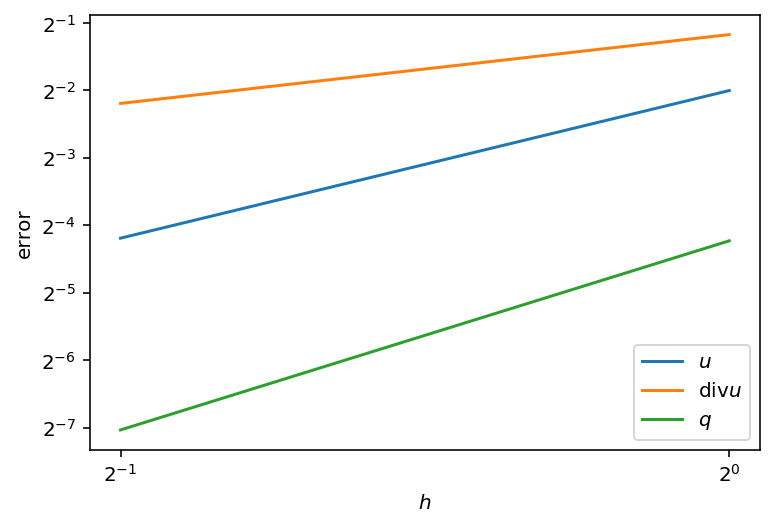

In [32]:
plt.loglog(1/np.array(ns), es, basex=2, basey=2)
plt.legend(['$u$',r'$\operatorname{div} u$', r'$q$'])
plt.xlabel('$h$')
plt.ylabel('error')

In [33]:
rates = -np.diff(np.log2(es), axis=0)
rates

array([[2.18820832, 1.0204998 , 2.80336741]])